# Import libs

In [47]:
import os
from threading import Thread  # needed since the denoiser is running in parallel
import queue

import numpy as np
import torch
import torch.optim
from models.skip import skip  # our network

from utils.utils import *  # auxiliary functions
from utils.data import Data  # class that holds img, psnr, time
from models.downsampler import Downsampler

from dncnn_models.network_dncnn import DnCNN as net_dncnn       # dncnn net
from dncnn_models.network_ffdnet import FFDNet as net_ffdnet    # FFDNet

from skimage.restoration import denoise_nl_means, estimate_sigma

import warnings
warnings.filterwarnings("ignore")


In [48]:
CUDA_FLAG = True  # got GPU?
CUDNN = True  # if you are not getting the exact article results set CUDNN to False
if CUDA_FLAG:
    os.environ['CUDA_VISIBLE_DEVICES'] = '0'
    # GPU accelerated functionality for common operations in deep neural nets
    torch.backends.cudnn.enabled = CUDNN
    torch.backends.cudnn.benchmark = CUDNN
    # torch.backends.cudnn.deterministic = True
    dtype = torch.cuda.FloatTensor
else:
    dtype = torch.FloatTensor

# Constants

In [49]:

ORIGINAL       = 'HR'
CORRUPTED      = 'LR'
BICUBIC        = 'Bicubic'
BICUBICNOISY   = 'Bicubicnoisy'
MIXEDCORRUPTED = 'MixedCorrupted'

DIP_NLM     = 'DRED (NLM)'
DIP_BM3D    = 'DRED (BM3D)' 
DIP_FFDNET  = 'DRED (FFDNET)' 
DIP_TEMP    = 'DIP_TEMP'


# Load image for Super-Resolution

In [50]:
from utils.denoising_utils import *       # 自己写的库(在utilis文件里)，加噪声函数
# from utils.sr_utils import *

def load_LR_HR_imgs_sr_addnoise(fname, factor,sigma, use_matlab_resize=False, plot=False):  # matlab_resize requires matlab engine
    #获取32倍数的原图：
    img_HR_pil, img_HR_np = load_and_crop_image(fname, d=32)  # crop by factor
    # 获取下采样的图：
    img_LR_pil, img_LR_np = pil_resize(img_HR_pil, factor)
    print('HR and LR resolutions: %s, %s' % (str(img_HR_pil.size), str (img_LR_pil.size)))
    
    #对低分辨率图像加噪声：
    img_noisy_LR_pil,img_LRnoisy_np=get_noisy_image(img_LR_np,sigma/255)  # 加噪部分
    
    # Gets `bicubic` baseline
    img_bicubic_pil = img_LR_pil.resize(img_HR_pil.size, Image.BICUBIC)
    img_bicubic_np = pil_to_np(img_bicubic_pil)

    # Gets `bicubic_noisy` baseline
    img_bicubicnoisy_pil = img_noisy_LR_pil.resize(img_HR_pil.size, Image.BICUBIC)
    img_bicubicnoisy_np = pil_to_np(img_bicubicnoisy_pil)

    data_dict = {ORIGINAL: Data(img_HR_np), CORRUPTED: Data(img_LR_np),
                 BICUBIC: Data(img_bicubic_np, compare_psnr(img_HR_np, img_bicubic_np)),
                 MIXEDCORRUPTED: Data(img_LRnoisy_np),
                 BICUBICNOISY: Data(img_bicubicnoisy_np, compare_psnr(img_HR_np, img_bicubicnoisy_np))
                 }
    if plot:
        #print('HR and LR resolutions:', img_HR_np.shape, img_LR_np.shape)
        plot_dict(data_dict)

    return data_dict

# Get the LR and HR images
sigma     = 25
FACTOR    = 4  # scale factor: 2 , 4 , 8
data_dict = load_LR_HR_imgs_sr_addnoise('/home/yuanweimin/PHD_3/YUAN_LASTEST_WORK/all_data/testsets/Set14/baboon.bmp', factor=FACTOR,sigma=sigma, plot=True)


HR and LR resolutions: (480, 480), (120, 120)


In [51]:

# #np.clip(data_dict[MIXEDCORRUPTED].img, 0, 1, out=data_dict[MIXEDCORRUPTED].img) 
# plt.imsave('./Input.png',data_dict[MIXEDCORRUPTED].img.transpose(1,2,0))

# plt.imsave('./Bicubic.png',data_dict[BICUBICNOISY].img.transpose(1,2,0))

# plt.imsave('./GT.png',data_dict[MIXEDCORRUPTED].img.transpose(1,2,0))

# THE NETWORK

In [52]:
def get_network_and_input(img_shape, input_depth=32, pad='reflection',
                          upsample_mode='bilinear', use_interpolate=True, align_corners=False,
                          act_fun='LeakyReLU', skip_n33d=128, skip_n33u=128, skip_n11=4,
                          num_scales=5, downsample_mode='stride', INPUT='noise'):  # 'meshgrid'
    """ Getting the relevant network and network input (based on the image shape and input depth)
        We are using the same default params as in DIP article
        img_shape - the image shape (ch, x, y)
    """
    n_channels = img_shape[0]
    net = skip(input_depth, n_channels,
               num_channels_down=[skip_n33d] * num_scales if isinstance(skip_n33d, int) else skip_n33d,
               num_channels_up=[skip_n33u] * num_scales if isinstance(skip_n33u, int) else skip_n33u,
               num_channels_skip=[skip_n11] * num_scales if isinstance(skip_n11, int) else skip_n11,
               upsample_mode=upsample_mode, use_interpolate=use_interpolate, align_corners=align_corners,
               downsample_mode=downsample_mode, need_sigmoid=True, need_bias=True, pad=pad, act_fun=act_fun).type(dtype)
    
    net_input = get_noise(input_depth, INPUT, img_shape[1:]).type(dtype).detach()
    return net, net_input

# Deep Learning Powered by RED, Our Generic Function
## The RED engine with Neural Network
## you may test it with any neural net, and any denoiser

In [53]:
def train_via_admm(net, net_input, denoiser_function, D, y, bicubic, HR_img=None,  # D is the downsampler, y is LR image
                   plot_array={}, algorithm_name="", save_path="",          # will save params and graphs in this folder
                   admm_iter=600, LR=0.0001, update_iter=10, method='grad',   # 'fixed_point' or 'grad' or 'mixed'
                   # sigma_f:FFDNET先验的输入参数
                   sigma_f=25, beta=0.05, mu=0.06, LR_x=None, noise_factor=.02):    # LR_x needed only if method!=fixed_point
    
    # get optimizer and loss function:
    optimizer = torch.optim.Adam(net.parameters(), lr=LR)  # using ADAM opt

    mse = torch.nn.MSELoss().type(dtype)  # using MSE loss

    # additional noise added to the input:
    net_input_saved = net_input.detach().clone()
    noise = net_input.detach().clone()
    
    # x update method:
    if method == 'fixed_point':
        swap_iter = admm_iter + 1
        LR_x = None
    elif method == 'grad':
        swap_iter = -1
    elif method == 'mixed':
        swap_iter = admm_iter // 2
    else:
        assert False, "method can only be 'fixed_point' or 'grad' or 'mixed' !"
        
    # initialize:
    x = np.zeros_like(bicubic)  # bicubic.copy()

    y_torch = np_to_torch(y).type(dtype) # y 就是DIP进行超分的目标(y_torch是其tensor)

    f_x = x.copy()

    # 拉格朗日乘子U初始化：
    u = np.zeros_like(x)

    psnr_net_list=[]
    psnr_hr      =[]
    psnr_x_list       =[] 
    image_list   =[]

    for i in range(1, 1 + admm_iter):

        # step 1, update network, eq. 7 in the article
        optimizer.zero_grad()
        net_input = net_input_saved + (noise.normal_() * noise_factor)
        out = net(net_input)
        out_np = torch_to_np(out)
        # loss:
        loss_y = mse(D(out), y_torch)
        
        loss_x = mse(out, np_to_torch(x - u).type(dtype))
        total_loss = loss_y + mu * loss_x  # SR任务上总的loss
        total_loss.backward()
        optimizer.step()
        
        # step 2, update x using a denoiser and result from step 1
        f_x = denoiser_function(x.copy(), sigma_f)

        # 因为随着迭代噪声变小，减少sigma_f的影响
        sigma_f = sigma_f - 0.01

        # 使用深度先验的话需要去掉一维：
        f_x=np.squeeze(f_x)
        
        # step 2, update x using a the denoiser (f_x) and network outputs (out_np)
        if i < swap_iter:
            x = 1 / (beta + mu) * (beta * f_x + mu * (out_np + u))      # eq. 11 in the article
        else:
            x = x - LR_x * (beta * (x - f_x) + mu * (x - out_np - u))   # eq. 12 in the article
        np.clip(x, 0, 1, out=x)  # making sure that image is in bounds

        # step 3, update u
        u = u + out_np - x
        
        increase_reg= 0.00
        mu = mu + increase_reg
        beta = beta + increase_reg
        # show psnrs:
        if HR_img is not None:

            psnr_x = compare_PSNR(HR_img, x, on_y=True)   # psnr of network output
            psnr_net = compare_PSNR(HR_img, out_np, on_y=True)   # psnr of network output
            psnr_x_u = compare_PSNR(HR_img, x - u,  on_y=True)    # the psnr of our result
            
            # 记录结果：
            psnr_hr.append(psnr_x_u)
            psnr_net_list.append(psnr_net)
            psnr_x_list.append(psnr_x)

            image_list.append(x-u)
            
            print('\r', algorithm_name, '%04d/%04d Loss %f' % (i, admm_iter, total_loss.item()),
                  'psnr net: %.2f psnr x-u: %.2f' % (psnr_net, psnr_x_u), end='')
        else:
            print('\r', algorithm_name, 'iteration %04d/%04d Loss %f' % (i, admm_iter, total_loss.item()), end='')
    
    return (x - u), psnr_hr,psnr_net_list,psnr_x_list,image_list


# Preparations

In [54]:
#case2:
from bm3d import bm3d

def non_local_means(noisy_np_img, sigma, fast_mode=True):
    """ get a numpy noisy image
        returns a denoised numpy image using Non-Local-Means
    """ 
    sigma = sigma / 255.
    h = 0.6 * sigma if fast_mode else 0.8 * sigma
    patch_kw = dict(h=h,                   # Cut-off distance, a higher h results in a smoother image
                    sigma=sigma,           # sigma provided
                    fast_mode=fast_mode,   # If True, a fast version is used. If False, the original version is used.
                    patch_size=5,          # 5x5 patches (Size of patches used for denoising.)
                    patch_distance=6,      # 13x13 search area
                    multichannel=False)
    
    denoised_img = []
    n_channels = noisy_np_img.shape[0]  # numpy_img size: [channel,h,w]
    for c in range(n_channels):
        denoise_fast = denoise_nl_means(noisy_np_img[c, :, :], **patch_kw)
        denoised_img += [denoise_fast]

    return np.array(denoised_img, dtype=np.float32)

def bm3d_yuan(noisy_np_img,sigma,fast_mode=True):
    sigma=sigma/255
    denoised_image=[]
    n_channels=noisy_np_img.shape[0]
    for c in range(n_channels):
        denoise_fast=bm3d(noisy_np_img[c,:,:],sigma)
        denoised_image+=[denoise_fast]
    return np.array(denoised_image,dtype=np.float32)


n_channels=1  #处理单通道图像
model_ffdnet=net_ffdnet(in_nc=n_channels,out_nc=n_channels,nc=64,nb=15,act_mode='R')
#预训练的DnCNN模型参数：
model_path_ffdnet='/home/yuanweimin/PHD_3/2019_ICCVW_DeepRED/model_zoo/ffdnet_gray.pth'

#加载训练参数：
model_ffdnet.load_state_dict(torch.load(model_path_ffdnet),strict=True)
model_ffdnet.eval()
#通常在实际代码中，在预测阶段，也会加上torch.no_grad()来关闭梯度的计算
for k, v in model_ffdnet.named_parameters():
    v.requires_grad = False


def FFDNet_yuan(noisy_np_img,sigma):
    noisy_torch_img=np_to_torch(noisy_np_img)
    n_channels=noisy_torch_img.shape[1]
    denoised_img=[]
    sigma_map=torch.full((1,1,1,1),sigma/255.).type_as(noisy_torch_img) # size:[1,1,1,1]
    #print(noisy_torch_img.shape)  # size:[1,3,256,256]

    for c in range(n_channels):
        # print(noisy_torch_img[:,c,:,:].shape)                 # tensor, size:[1,256,256]
        temp=torch.unsqueeze(noisy_torch_img[:,c,:,:],dim=0)  # tensor, size:[1,1,256,256] (增加一维)
        
        denoise_torch_fast=model_ffdnet(temp,sigma_map)                # denoise_torch_fast:[1,1,256,256]
        #print(denoise_torch_fast.shape)

        denoise_np_fast=torch_to_np(denoise_torch_fast)       # denoise_np_fast:[1,256,256]
        #print(denoise_np_fast.shape)
        denoised_img+=[denoise_np_fast]   
    return np.array(denoised_img, dtype=np.float32) 

In [55]:
# 处理rgb图像：

n_channels_color=3  #处理单通道图像
# 实例化：
model_ffdnet_color=net_ffdnet(in_nc=n_channels_color,out_nc=n_channels_color,nc=96,nb=12,act_mode='R')
#预训练的FFDNet模型参数：(使用绝对路径！)
model_path_ffdnet_color='/home/yuanweimin/PHD_3/2019_ICCVW_DeepRED/model_zoo/ffdnet_color.pth'

#加载训练参数：
model_ffdnet_color.load_state_dict(torch.load(model_path_ffdnet_color),strict=True)
model_ffdnet_color.eval()
#通常在实际代码中，在预测阶段，也会加上torch.no_grad()来关闭梯度的计算
for k, v in model_ffdnet_color.named_parameters():
    v.requires_grad = False

def FFDNet_color_yuan(noisy_np_img,sigma):
    noisy_torch_img=np_to_torch(noisy_np_img)

    n_channels=noisy_torch_img.shape[1]
    denoised_img=[]
    sigma_map=torch.full((1,1,1,1),sigma/255.).type_as(noisy_torch_img) # size:[1,1,1,1]
    #print(noisy_torch_img.shape)  # size:[1,3,256,256]

    
    # print(noisy_torch_img[:,c,:,:].shape)                 # tensor, size:[1,256,256]
    #temp=torch.unsqueeze(noisy_torch_img[:,c,:,:],dim=0)  # tensor, size:[1,1,256,256] (增加一维)
    
    denoise_torch_fast=model_ffdnet_color(noisy_torch_img,sigma_map)                # denoise_torch_fast:[1,1,256,256]
    #print(denoise_torch_fast.shape)

    denoise_np_fast=torch_to_np(denoise_torch_fast)       # denoise_np_fast:[1,256,256]
    #print(denoise_np_fast.shape)
    denoised_img+=[denoise_np_fast]   
    return np.array(denoised_img, dtype=np.float32)

In [56]:
# 更新后的DnCNN:

#case3: DnCNN as a denoiser 
n_channels=1  #处理单通道图像
# 实例化DnCNN:
dncnn_model=net_dncnn(in_nc=n_channels, out_nc=n_channels,nc=64,nb=17,act_mode='R')

#预训练的DnCNN模型参数：
model_path='/home/yuanweimin/PHD_3/2019_ICCVW_DeepRED/model_zoo/dncnn_25.pth'

#加载训练参数：
dncnn_model.load_state_dict(torch.load(model_path),strict=True)
dncnn_model.eval()
#通常在实际代码中，在预测阶段，也会加上torch.no_grad()来关闭梯度的计算
for k, v in dncnn_model.named_parameters():
    v.requires_grad = False



def DnCNN_yuan(noisy_np_img,sigma):


    #print(model)
    ####################################################################
    sigma=sigma/255
    noisy_torch_img=np_to_torch(noisy_np_img)
    #print(noisy_torch_img.shape[1])
    channels=noisy_torch_img.shape[1]
    denoised_img=[]
    for c in range(channels):
        # print(noisy_torch_img[:,c,:,:].shape)
        # print(noisy_torch_img.shape)
        denoise_torch_fast=dncnn_model(noisy_torch_img[:,c,:,:])  
        denoise_np_fast=torch_to_np(denoise_torch_fast)
        denoised_img+=[denoise_np_fast]

    return np.array(denoised_img, dtype=np.float32)    


Ready to go, (3, 120, 120) -> (3, 480, 480)
 DIP_TEMP 0500/0500 Loss 0.005585 psnr net: 20.72 psnr x-u: 21.10

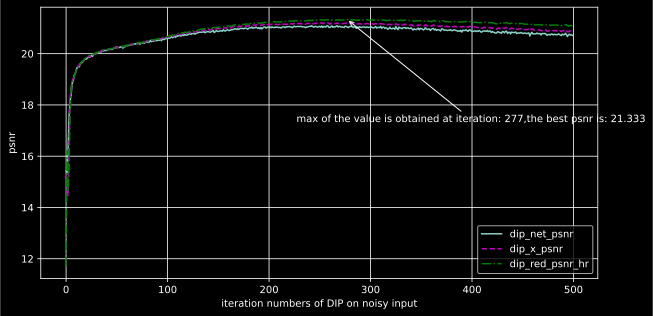

In [57]:
def run_and_plot(denoiser, name, plot_checkpoints={}):
    global data_dict
    # print:
    print("Ready to go, %s -> %s" % (data_dict[CORRUPTED].img.shape, data_dict[ORIGINAL].img.shape))
    # get net, input, and downsampler:
    net, net_input = get_network_and_input(img_shape=data_dict[ORIGINAL].img.shape)

    ds = Downsampler(n_planes=data_dict[CORRUPTED].img.shape[0], factor=FACTOR,
                 kernel_type='lanczos2', phase=0.5, preserve_size=True).type(dtype)
    
                                # 在此处测试有无噪声的输入：CORRUPTED or MIXEDCORRUPTED
    # run the generic function: # D, y: data_dict[CORRUPTED/MIXEDCORRUPTED].img
    sr_img, psnr_hr,psnr_net_list,psnr_x_list,image_list = train_via_admm(net, net_input, denoiser, ds, data_dict[MIXEDCORRUPTED].img, data_dict[BICUBIC].img,
                            plot_array=plot_checkpoints, algorithm_name=name,
                            admm_iter=500,
                            LR=0.001,
                            method='fixed_point',   # 'fixed_point' or 'grad' or 'mixed'
                            LR_x=None,       # LR_x needed only if method!=fixed_point
                            HR_img=data_dict[ORIGINAL].img,
                            sigma_f=sigma, 
                            beta=0.1, 
                            mu=0.2,
                            noise_factor=.02
                            )
    
    data_dict[name] = Data(sr_img, compare_PSNR(data_dict[ORIGINAL].img, sr_img, on_y=True))
    #plot_dict(data_dict)

    return sr_img,psnr_hr,psnr_net_list,psnr_x_list,image_list 

plot_checkpoints = {1, 10, 100, 1000, 1500}

#                     denoiser choice: non_local_means, bm3d_yuan, DnCNN_yuan, FFDNet_yuan
#                                      DIP_NLM,         DIP_BM3D,  DIP_DNCNN,  DIP_FFDNET   
sr_img,psnr_hr,psnr_net_list,psnr_x_list,image_list = run_and_plot(FFDNet_color_yuan, DIP_TEMP, plot_checkpoints)
############################################################################################################
from d2l import torch as d2l
import matplotlib.pyplot as plt
net_max=max(psnr_hr)                       
net_max_index=psnr_hr.index(net_max)   
def annotate(text, xy, xytext):
    d2l.plt.gca().annotate(text, xy=xy, xytext=xytext,arrowprops=dict(arrowstyle='->'))
x=torch.arange(0,500,1)
d2l.plot(x.numpy(),[psnr_net_list,psnr_x_list,psnr_hr],xlabel='iteration numbers of DIP on noisy input',ylabel='psnr',legend=['dip_net_psnr','dip_x_psnr','dip_red_psnr_hr'],figsize=(10,5))
text_label='max of the value is obtained at iteration: '+str(net_max_index)+','+'the best psnr is: '+str(round(net_max,3))
annotate(text=text_label,xy=(net_max_index,net_max),xytext=(net_max_index-50,net_max-4))

In [58]:
# # part1: 总的PSNR曲线：
# from d2l import torch as d2l
# import matplotlib.pyplot as plt
# # 获取psnr_avg_list列表的最大值和对应索引
# net_max=max(psnr_hr)                       
# net_max_index=psnr_hr.index(net_max)   
# #标注函数
# def annotate(text, xy, xytext):
#     d2l.plt.gca().annotate(text, xy=xy, xytext=xytext,arrowprops=dict(arrowstyle='->'))
# x=torch.arange(0,100,1)
# d2l.plot(x.numpy(),[psnr_net_list,psnr_x_list,psnr_hr],xlabel='iteration numbers of DIP on noisy input',ylabel='psnr',legend=['dip_net_psnr','dip_x_psnr','dip_red_psnr_hr'],figsize=(10,5))
# text_label='max of the value is obtained at iteration: '+str(net_max_index)+','+'the best psnr is: '+str(round(net_max,3))
# annotate(text=text_label,xy=(net_max_index,net_max),xytext=(net_max_index-50,net_max-5))
# # part2: 显示最优的那张结果：
# optimal_img=image_list[net_max_index]
# data_dict[DIP_TEMP] = Data(optimal_img, compare_PSNR(data_dict[ORIGINAL].img, optimal_img, on_y=True))
# plot_dict(data_dict)

In [59]:
# # # 保存最优的结果
# # print(optimal_img.shape)
# temp = data_dict[MIXEDCORRUPTED].img

# # np.clip(optimal_img, 0, 1, out=optimal_img) 
# plt.imsave('./YUAN_18.29.png',optimal_img.transpose(1,2,0))